In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Max time,  1460


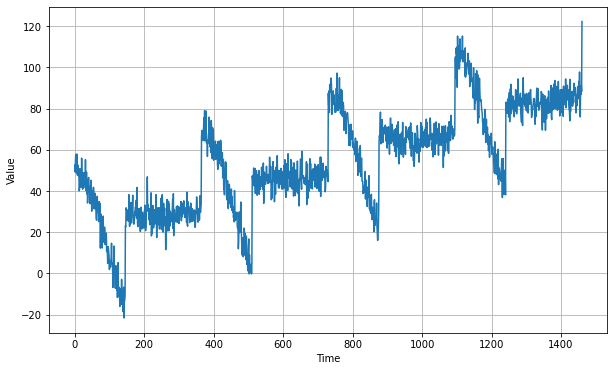

In [27]:
time = np.arange(4 * 365 + 1)
print('Max time, ', max(time))

slope = 0.05
baseline = 10
amplitude = 40

# series created
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

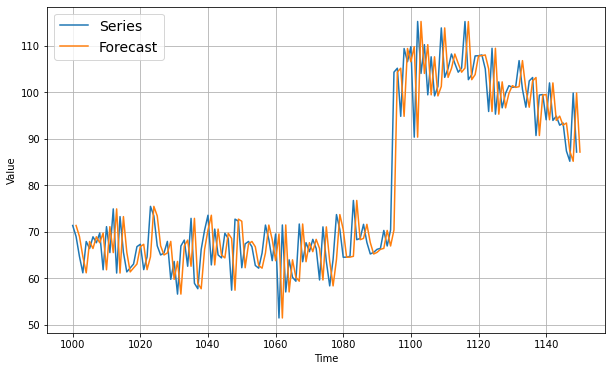

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

naive_forecast = series[split_time - 1:-1]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [5]:
print('MSE naive, ', keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

MSE naive,  5.9379085153216735


2022-08-05 09:17:11.089261: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 09:17:11.110549: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 09:17:11.111983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-05 09:17:11.114514: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [6]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [7]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast
     This implementation is *much* faster than the previous one"""
  mov = np.cumsum(series)
  mov[window_size:] = mov[window_size:] - mov[:-window_size]
  return mov[window_size - 1:-1] / window_size

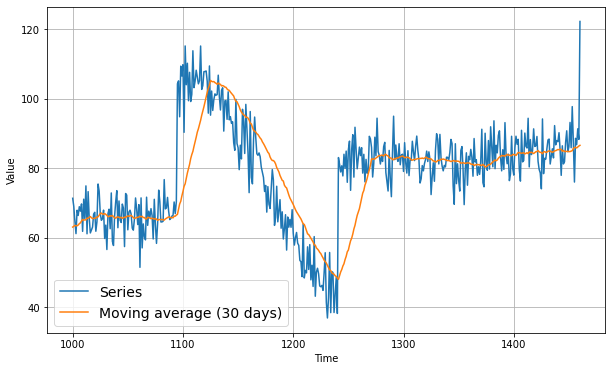

In [8]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Moving average (30 days)")

In [9]:
print("MSE moving ave, ", keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

MSE moving ave,  7.1424185706207854


Len. diff time, 1096
Len series[365:], 1096
Len series[:-365], 1096


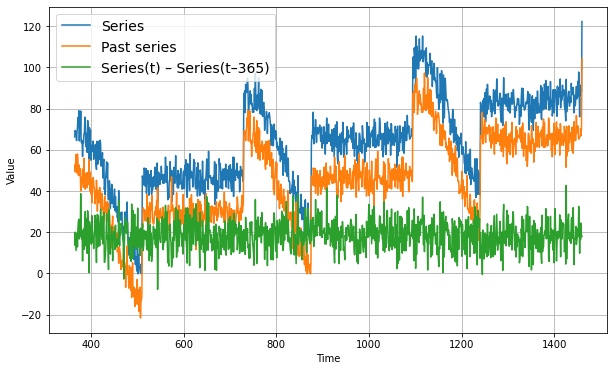

In [38]:
#The moving average does not anticipate trend or seasonality.  remove the seasonality by subtracting the value at time t-365
diff_series = (series[365:] - series[:-365])  # The index running from 365:
diff_time = time[365:]                        # ditto
print('Len. diff time,', len(diff_time))
print('Len diff series[365:],', len(series[365:]))
print('Len diff series[:-365],', len(series[:-365]))

plt.figure(figsize=(10, 6))
plot_series(diff_time, series[365:], label='Series')
plot_series(diff_time, series[:-365], label='Past series')
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

Len. diff. series split_time: 96


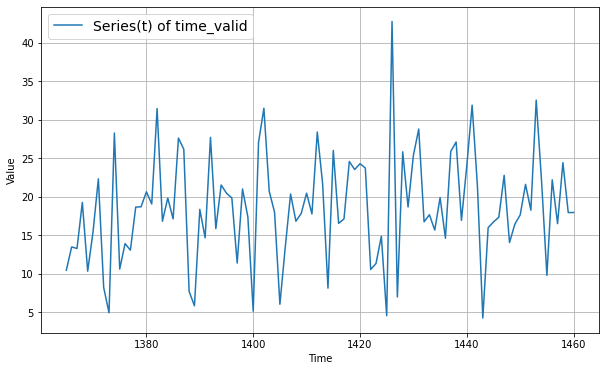

Len. diff. series [split_time - 365:: 461


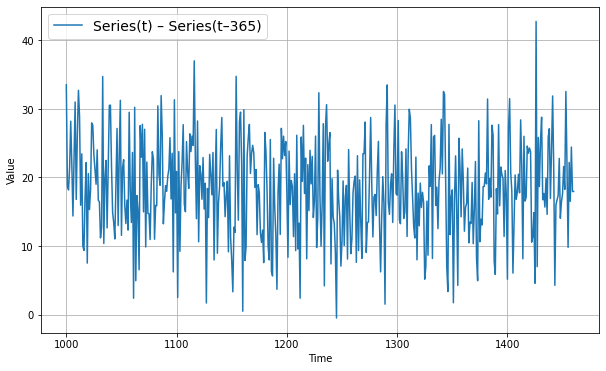

In [45]:
plt.figure(figsize=(10, 6))
print('Len. diff. series split_time:', len(diff_series[split_time:]))
plot_series(time_valid[365:], diff_series[split_time:], label="Series(t) of time_valid")
plt.show()

print('Len. diff. series [split_time - 365::', len(diff_series[split_time  - 365:]))
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()

In [12]:
# exercise to test the indexing change and the len of the list
test = []
ind =1000
for i in range(1300):
    test.append(i)
print(len(test))
print(len(test[ind - 365:]))

1300
665


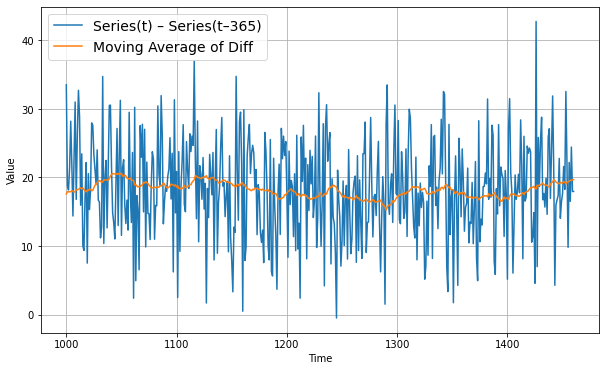

In [20]:
# moving average for validation data
window_size = 50
diff_moving_avg = moving_average_forecast(diff_series, window_size)[split_time - 365 - window_size:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

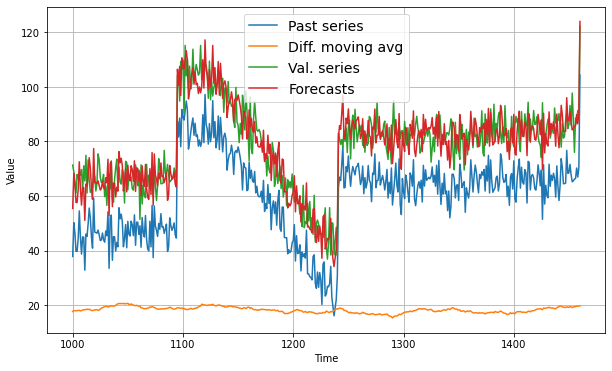

In [47]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, series[split_time - 365:-365], label="Past series")
plot_series(time_valid, diff_moving_avg, label="Diff. moving avg")
plot_series(time_valid, x_valid, label="Val. series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()

In [48]:
print('MSE diff_moving_avg_plus_past,',keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

MSE diff_moving_avg_plus_past, 5.8393105629958955


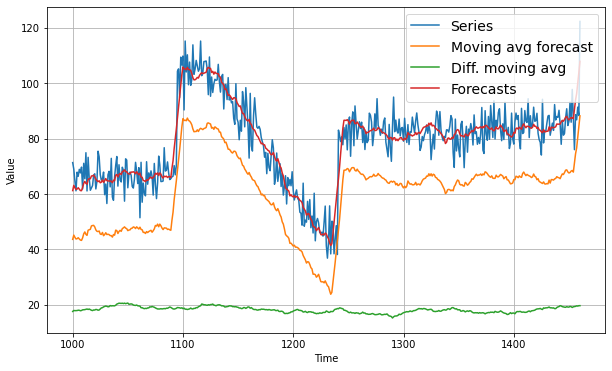

In [50]:
#moving average helps to remove noise.
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_average_forecast(series[split_time - 370:-359], 11), label="Past moving avg forecast")
plot_series(time_valid, diff_moving_avg, label="Diff. moving avg")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()

In [25]:
print('MSE diff moving avg plus smooth past,', keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

MSE diff moving avg plus smooth past, 4.566859958970772
